<u>Reload modules</u>

In [1]:
%load_ext autoreload
%autoreload 2

<u>Imports</u>

In [2]:
# imports

import os
from os import listdir
from os.path import isfile, split, join

# Calculus

import numpy as np
import pandas as pd

# Audio processing

from midi2audio import FluidSynth
import pretty_midi as pm
import librosa
import mido
from mido import MidiFile, MidiTrack, Message, MetaMessage

# Image processing

from PIL import Image

# Display

import matplotlib.pyplot as plt

# Model

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout
import keras

2024-03-09 08:07:15.530650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<u>Paths</u>

In [3]:
midi_path = "./data/midis/Aaron, Michael, Piano Course, V8WvKK-1b2c.mid"
chunk_directory = "./data/chunks"
wav_directory = "./data/wav"
spect_directory = "./data/spect"



<u>Useful functions</u>

function 1: <b>create chunks</b>

<FONT COLOR="#ff0000"><b>!!! Code from github project !!!</b></FONT>

In [59]:
def split_midi_into_chunks(mid_file, target_directory, default_tempo=500000, target_segment_len=1):

# Split the "mid_file" into many chunks and store them in the "target_dir"

  song_name = split(mid_file)[-1][:-4]
  mid = MidiFile(mid_file)

# identify the meta messages

  metas = []
  tempo = default_tempo
  for msg in mid:
    if msg.type == 'set_tempo':
      tempo = msg.tempo
    if msg.is_meta:
      metas.append(msg)
  for meta in metas:
    meta.time = int(mido.second2tick(meta.time, mid.ticks_per_beat, tempo))

  target = MidiFile()
  track = MidiTrack()
  track.extend(metas)
  target.tracks.append(track)
  prefix = 0
  time_elapsed = 0
  for msg in mid:
    # Skip non-note related messages
    if msg.is_meta:
      continue
    time_elapsed += msg.time
    if msg.type != 'end_of_track':
      msg.time = int(mido.second2tick(msg.time, mid.ticks_per_beat, tempo))
      track.append(msg)
    if msg.type == 'end_of_track' or time_elapsed >= target_segment_len:
      track.append(MetaMessage('end_of_track'))
      target.save(join(target_directory, song_name + '_{}.mid'.format(prefix)))
      target = MidiFile()
      track = MidiTrack()
      track.extend(metas)
      target.tracks.append(track)
      time_elapsed = 0
      prefix += 1

function 2: <b>convert midi to audio .wav and save them </b>

In [5]:
def convert_midi_to_wav(input_path=chunk_directory,output_path=wav_directory,soundfont="./soundfont/FluidR3_GM.sf2",data_size=100):

    # Converts the midi files in "input_path" into .wav audio files and store them in "output_path"

    wav_name_list = []
    
    files = list(os.scandir(input_path))

    for file in files[0:data_size]:
        fs = FluidSynth(soundfont)
        input = os.path.join(input_path, file.name)
        output = os.path.join(output_path, f"{file.name}.wav")
        fs.midi_to_audio(input,output)
        wav_name_list.append(f"{file.name}")

    return wav_name_list

function 3: <b>convert .wav into spectograms and save them </b>(X preprocessing step)

In [6]:
def from_audio_to_spectograms(input_path=wav_directory,output_path=spect_directory):
    
    indexing_value = 0
    spect_name_list = []
    files = [file for file in os.scandir(wav_directory) if file.name[-4:]==".wav"]

    for file in files :
        y, sr = librosa.load(file, sr=None)
        S = np.abs(librosa.stft(y))
        fig, ax = plt.subplots()
        img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),y_axis='log', x_axis='time', ax=ax)
        plt.axis('off')
        output_name = f'spectrogram{indexing_value}.png'
        plt.savefig(os.path.join(output_path, output_name))
        plt.close(fig)
        spect_name_list.append(output_name[:-4])
        indexing_value = indexing_value + 1
    
    return spect_name_list

function 4: <b>returns clean & normalized X_normalized from a list of spectogram image </b>(X)

In [7]:
def from_img_to_array (input_path=spect_directory,img_size=(49,154)):
    
    array_img_list = []

    name_list = [file.name for file in os.scandir(input_path) if file.name[-4:]==".png"]
    
    for name in name_list :
        
        # Removes the white frame and resizes the image
        step1 = Image.open(os.path.join(input_path, name)).crop((80,58,576,427)).resize(img_size, Image.NEAREST)
        
        # Converts the image into np.array (RGBA)
        step2 = np.array(step1)

        # Normalizes the data 
        step3 = step2 / 255

        # removes the last dimension (A -> transparency) which is useless
        step4 = step3[:, :, :3] 

        array_img_list.append(step4)

    X_normalized = np.array(array_img_list).reshape(len(array_img_list),img_size[0],img_size[1],3)
    
    return X_normalized

Step 5: <b>encoding midi files notes </b>(preparation for y)

<FONT COLOR="#ff0000"><b>!!! Code from github project !!!</b></FONT>

In [8]:
#def pretty_midi_to_one_hot(pretty_midi_file, fs=100):
#    one_hot = np.zeros((128, int(fs*pretty_midi_file.get_end_time())+1))
#    for note in pretty_midi_file.instruments[0].notes:
#        one_hot[note.pitch, int(note.start*fs)] = 1
#        #print('note on',note.pitch, int(note.start*fs))
#        one_hot[note.pitch, int(note.end*fs)] = 0
#        #print('note off',note.pitch, int(note.end*fs))
#    return one_hot

def pretty_midi_to_one_hot(pm, fs=100):
    """Compute a one hot matrix of a pretty midi object
    Parameters
    ----------
    pm : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    Returns
    -------
    one_hot : np.ndarray, shape=(128,times.shape[0])
        Piano roll of this instrument. 1 represents Note Ons,
        -1 represents Note offs, 0 represents constant/do-nothing
    """

    # Allocate a matrix of zeros - we will add in as we go
    one_hots = []

    if len(pm.instruments) < 1:
        return 0

    for instrument in pm.instruments:
        one_hot = np.zeros((128, int(fs*instrument.get_end_time())+1))
        for note in instrument.notes:
            # note on
            one_hot[note.pitch, int(note.start*fs)] = 1
            # print('note on',note.pitch, int(note.start*fs))
            # note off
            one_hot[note.pitch, int(note.end*fs)] = 0
            # print('note off',note.pitch, int(note.end*fs))
        one_hots.append(one_hot)

    one_hot = np.zeros((128, np.max([o.shape[1] for o in one_hots])))
    for o in one_hots:
        one_hot[:, :o.shape[1]] += o

    one_hot = np.clip(one_hot,-1,1)
    return one_hot

def slice_to_categories(piano_roll):
    notes_list = np.zeros(128)
    notes = np.nonzero(piano_roll)[0]
    notes = np.unique(notes)

    for note in notes:
        notes_list[note] = 1

    return notes_list

Step 6: <b>turns midi chunks into arrays </b>(y "one hot" encoded)

In [18]:
def midi_to_oh_arrays (wav_name_list, input_path = chunk_directory) :
    
    y_list = []
    
    chunk_to_encode = wav_name_list
    
    for chunk in chunk_to_encode :
        step0 = pm.PrettyMIDI(os.path.join(chunk_directory, chunk))
        step1 = pretty_midi_to_one_hot(step0)
        step2 = slice_to_categories(step1)
        y_list.append(step2)

    y_encoded = np.array(y_list)
    
    return y_encoded

<u>Create X and y</u>

In [10]:
data_size = 100

In [11]:
split_midi_into_chunks(midi_path,chunk_directory)

In [12]:
wav_name_list=convert_midi_to_wav(data_size=data_size)

fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_735.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_721.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_709.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_912.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_906.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_10.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_251.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_537.mid.wav'..
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_523.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_245.mid.wav'..
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_38.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_279.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_292.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_1002.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_1016.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_286.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_325.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_443.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_457.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_331.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_319.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_480.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_494.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_899.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_641.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_127.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_133.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_655.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_669.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_682.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_696.mid.wav'..
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_866.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_872.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_873.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_867.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_697.mid.wav'..
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_683.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_668.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_132.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_654.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_640.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_898.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_126.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_495.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_481.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_318.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_456.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_330.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_324.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_442.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_287.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_1017.mid.wav'..
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_1003.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_293.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_278.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_39.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_522.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_244.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_250.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_11.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_536.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_907.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_913.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_708.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_720.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_734.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_722.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_736.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_939.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_905.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_911.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_246.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_520.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_534.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_13.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_252.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_508.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_1015.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_285.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_291.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_1001.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_1029.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_332.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_454.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_440.mid.wav'..
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_326.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_468.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_497.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_483.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_656.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_130.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_124.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_642.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_118.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_695.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_681.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_859.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_871.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_865.mid.wav'..
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Aaron, Michael, Piano Course, V8WvKK-1b2c_864.mid.wav'..


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


In [13]:
spect_name_list = from_audio_to_spectograms()

In [61]:
img_size=(49,154)

In [62]:
X_normalized = from_img_to_array(img_size=img_size)
X_normalized.shape

(100, 100, 300, 3)

In [63]:
y_encoded = midi_to_oh_arrays(wav_name_list)
y_encoded.shape

(100, 128)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

<u>Model creation and training</u>

In [25]:
epochs = 100
batch_size = 32
learning_rate = .0001

In [65]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1),activation='tanh',input_shape=(img_size[0], img_size[1], 3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(32, (3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='softmax'))

In [66]:
model.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])

In [67]:
model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1)

Epoch 1/100
3/3 [==============================] - 6s 1s/step - loss: 0.6323 - accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 4s 1s/step - loss: 0.4011 - accuracy: 0.0125
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 0.2301 - accuracy: 0.0250
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 0.1399 - accuracy: 0.0625
Epoch 5/100
3/3 [==============================] - 4s 1s/step - loss: 0.1067 - accuracy: 0.0750
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.0945 - accuracy: 0.1250
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 0.0877 - accuracy: 0.1500
Epoch 8/100
3/3 [==============================] - 4s 1s/step - loss: 0.0810 - accuracy: 0.1500
Epoch 9/100
3/3 [==============================] - 4s 1s/step - loss: 0.0764 - accuracy: 0.1250
Epoch 10/100
3/3 [==============================] - 4s 1s/step - loss: 0.0720 - accuracy: 0.1375
Epoch 11/100
3/3 [=================

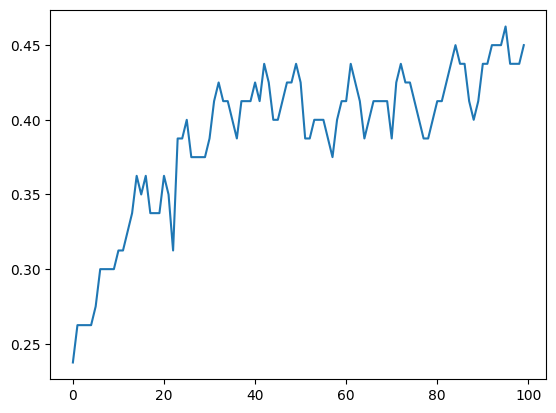

In [28]:
plt.plot(model.history.history["accuracy"])

<u>Prediction</u>

In [38]:
y_predict = (model.predict(X_test) > 0.5).astype(int)

1/1 [==============================] - 0s 80ms/step


In [54]:
y_predict[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [56]:
y_predict[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [57]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [58]:
from sklearn.metrics import accuracy_score
accuracy_score(y_predict,y_test)

0.2